In [ ]:
!pip install -q kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']="/content"

In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
 99% 2.68G/2.70G [00:11<00:00, 273MB/s]
100% 2.70G/2.70G [00:11<00:00, 246MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/new-plant-diseases-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import skimage
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

In [ ]:


# The path of the dataset
train_data_path = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_data_path = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

categories = os.listdir(train_data_path)
print(f'The Number Of categories are : {len(categories)} Category')

The Number Of categories are : 38 Category


In [ ]:
cat_freq = {}
for cat in categories:
    cat_freq[cat] = len(os.listdir(train_data_path + "/" + cat))

cat_freq_df = pd.DataFrame.from_dict(cat_freq, orient='index', columns=['Frequencies'])

cat_freq_df.reset_index(inplace=True)
cat_freq_df.columns = ['Categories', 'Frequencies']
cat_freq_df

,Categories,Frequencies
0,Apple___Black_rot,1987
1,Corn_(maize)___Common_rust_,1907
2,Tomato___Tomato_mosaic_virus,1790
3,Tomato___Spider_mites Two-spotted_spider_mite,1741
4,Tomato___Leaf_Mold,1882
5,Tomato___Septoria_leaf_spot,1745
6,Grape___Black_rot,1888
7,Peach___Bacterial_spot,1838
8,Orange___Haunglongbing_(Citrus_greening),2010
9,Tomato___Early_blight,1920


In [ ]:
cat_freq_df.describe()

,Frequencies
count,38.000000
mean,1849.868421
std,105.724315
min,1642.000000
25%,1763.500000
50%,1844.500000
75%,1924.500000
max,2022.000000


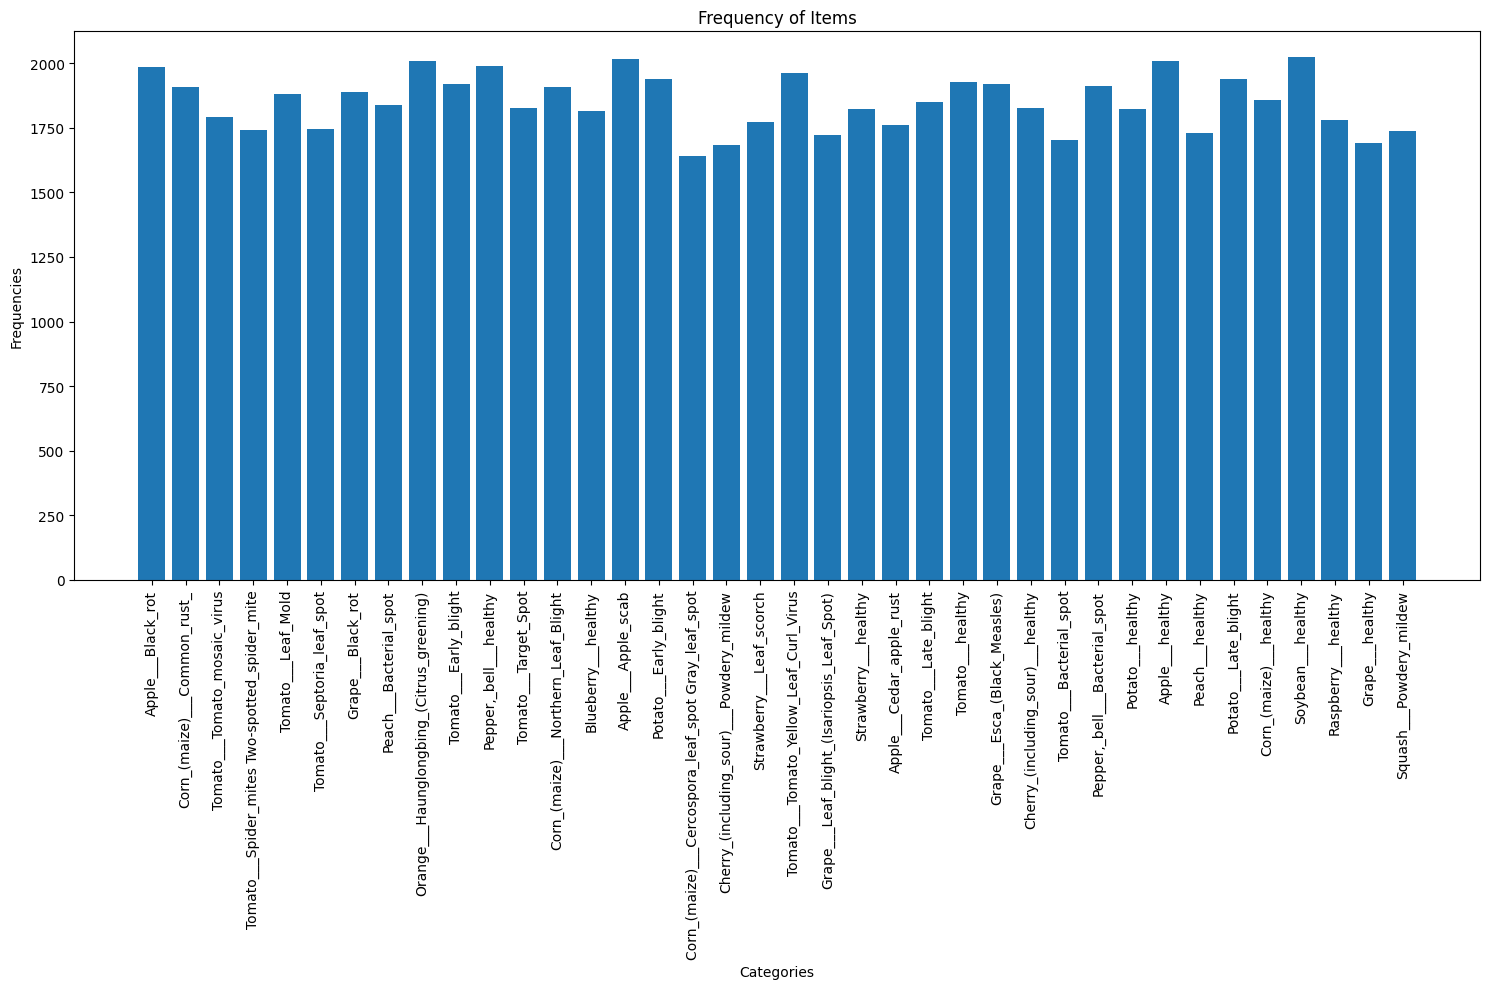

In [ ]:
plt.figure(figsize=(15, 10))
plt.bar(cat_freq_df['Categories'], cat_freq_df['Frequencies'])
plt.xlabel('Categories')
plt.ylabel('Frequencies')
plt.title('Frequency of Items')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
fruits_veg = []
for cat in categories:
    fruits_veg.append(cat.split('___')[0])
unique_fruites_veg = list(np.unique(fruits_veg))

print(f'The represents {len(unique_fruites_veg)} Different types of Fruits and Vegetables as follows : ')
unique_fruites_veg

The represents 14 Different types of Fruits and Vegetables as follows : 


['Apple',
 'Blueberry',
 'Cherry_(including_sour)',
 'Corn_(maize)',
 'Grape',
 'Orange',
 'Peach',
 'Pepper,_bell',
 'Potato',
 'Raspberry',
 'Soybean',
 'Squash',
 'Strawberry',
 'Tomato']

In [ ]:
veg_fruite_cat = {}
for i in unique_fruites_veg:
    num = 0
    for j in categories:
        if i in j:
            num +=1
    veg_fruite_cat[i] = num
veg_fruite_cat

{'Apple': 4,
 'Blueberry': 1,
 'Cherry_(including_sour)': 2,
 'Corn_(maize)': 4,
 'Grape': 4,
 'Orange': 1,
 'Peach': 2,
 'Pepper,_bell': 2,
 'Potato': 3,
 'Raspberry': 1,
 'Soybean': 1,
 'Squash': 1,
 'Strawberry': 2,
 'Tomato': 10}

In [ ]:
# Define paths for the sampled dataset
sampled_train_dir = 'Dataset\\Sampled\\train\\'
sampled_valid_dir = 'Dataset\\Sampled\\valid\\'

In [ ]:

# Create directories if they don't exist
os.makedirs(sampled_train_dir, exist_ok=True)
os.makedirs(sampled_valid_dir, exist_ok=True)

In [ ]:
def sample_dataset(data_dir, output_dir, sample_size=0.1):
    """
    Sample a subset of the dataset.

    Parameters:
    - data_dir: The directory containing the original dataset.
    - output_dir: The directory where the sampled dataset will be stored.
    - sample_size: The fraction of the dataset to sample.
    """
    categories = os.listdir(data_dir)

    for category in categories:
        # Create category directory in the sampled output directory
        os.makedirs(os.path.join(output_dir, category), exist_ok=True)

        # Get all images in the current category
        images = os.listdir(os.path.join(data_dir, category))

        # Sample a fraction of the images
        sampled_images = np.random.choice(images, int(len(images) * sample_size), replace=False)

        # Copy the sampled images to the output directory
        for image in sampled_images:
            src = os.path.join(data_dir, category, image)
            dst = os.path.join(output_dir, category, image)
            shutil.copy(src, dst)

In [ ]:
# Sample 10-20% of the dataset
sample_percentage = 0.6 # Adjust between 0.1 and 0.2 for 10-20%
sample_dataset(train_data_path, sampled_train_dir, sample_percentage)
sample_dataset(valid_data_path, sampled_valid_dir, sample_percentage)

In [ ]:
# Set up ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:

# Create training data generator
train_generator = train_datagen.flow_from_directory(
    sampled_train_dir,
    target_size=(256, 256),  # Resize images to match model input
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Create validation data generator
validation_generator = validation_datagen.flow_from_directory(
    sampled_valid_dir,
    target_size=(256, 256),  # Resize images to match model input
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 42161 images belonging to 38 classes.
Found 10532 images belonging to 38 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
# Load the MobileNet model with pre-trained weights on ImageNet, excluding the top layers


base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer with 1024 units and ReLU activation
x = Dense(1024, activation='relu')(x)

# Add a final softmax layer with the number of classes (38 in your case)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Compile the model

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# Define callbacks
checkpoint_path = "best_MobileNet_model.h5"  # Path where the best model will be saved

checkpoint = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_accuracy', patience=3, mode='max', verbose=1, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.0001
)

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [ ]:
# Train the model
history = model.fit(
    train_generator,  # Your training data generator
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=validation_generator,  # Your validation data generator
    callbacks=[checkpoint, early_stopping, reduce_lr]  # Add the callbacks here
)

Epoch 1/10
1318/1318 [==============================] - ETA: 0s - loss: 0.2907 - accuracy: 0.9102 - precision: 0.9413 - recall: 0.8885
Epoch 1: val_accuracy improved from -inf to 0.93619, saving model to best_MobileNet_model.h5
1318/1318 [==============================] - 385s 291ms/step - loss: 0.2907 - accuracy: 0.9102 - precision: 0.9413 - recall: 0.8885 - val_loss: 0.1845 - val_accuracy: 0.9362 - val_precision: 0.9428 - val_recall: 0.9274 - lr: 0.0010
Epoch 2/10
1318/1318 [==============================] - ETA: 0s - loss: 0.1155 - accuracy: 0.9609 - precision: 0.9665 - recall: 0.9564
Epoch 2: val_accuracy improved from 0.93619 to 0.94464, saving model to best_MobileNet_model.h5
1318/1318 [==============================] - 384s 292ms/step - loss: 0.1155 - accuracy: 0.9609 - precision: 0.9665 - recall: 0.9564 - val_loss: 0.1674 - val_accuracy: 0.9446 - val_precision: 0.9512 - val_recall: 0.9382 - lr: 0.0010
Epoch 3/10
1318/1318 [==============================] - ETA: 0s - loss: 0.085

In [ ]:
best_model = tf.keras.models.load_model('best_MobileNet_model.h5')

In [ ]:


loss, accuracy,precison,recall = best_model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')
print(f'Validation Precision: {precison}')
print(f'Validation Recall: {recall}')

330/330 [==============================] - 76s 229ms/step - loss: 0.0655 - accuracy: 0.9807 - precision: 0.9816 - recall: 0.9803
Validation Loss: 0.06550586968660355
Validation Accuracy: 0.9807254076004028
Validation Precision: 0.9816487431526184
Validation Recall: 0.9802506566047668


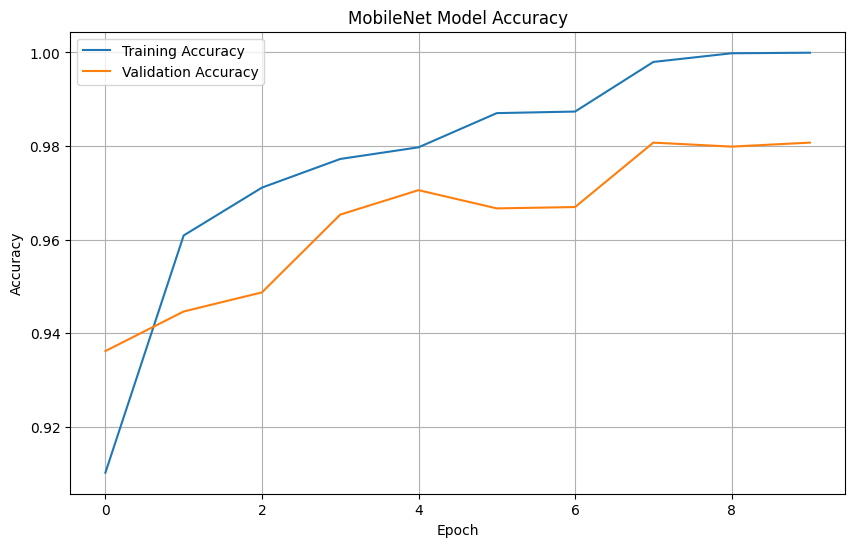

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

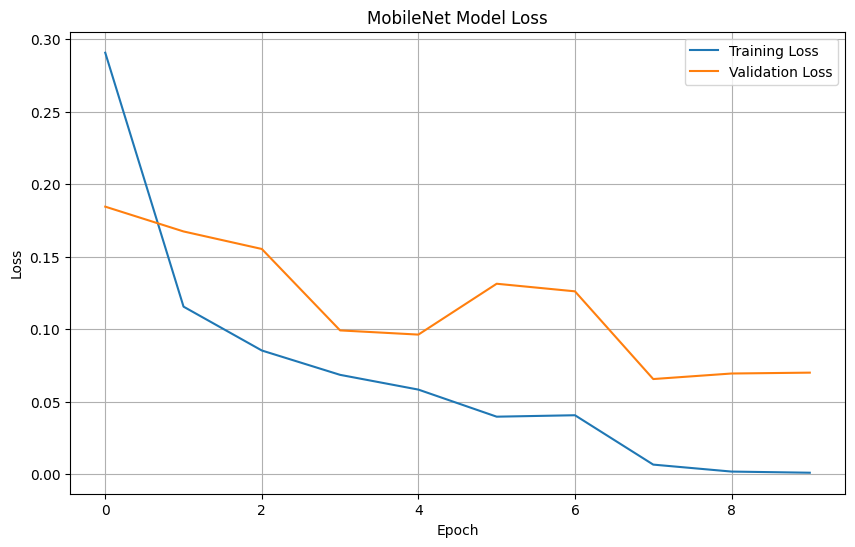

In [ ]:
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('MobileNet Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc='upper right')
  plt.grid(True)
  plt.show()

330/330 [==============================] - 77s 233ms/step


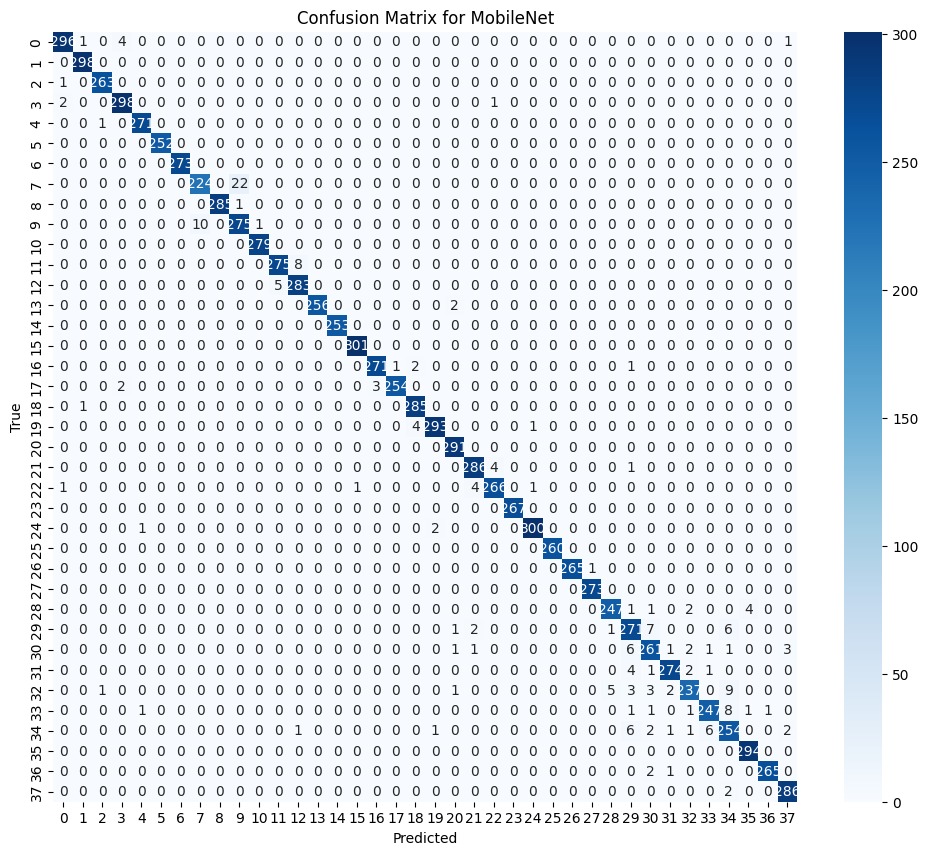

In [ ]:
from sklearn.metrics import confusion_matrix

Y_pred = best_model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for MobileNet')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import f1_score, roc_curve, auc, r2_score
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
validation_generator.reset()

y_pred = best_model.predict(validation_generator, verbose=1)
y_pred_class = np.argmax(y_pred, axis=1)

y_true = validation_generator.classes
class_indices = validation_generator.class_indices

inverse_class_indices = {v: k for k, v in class_indices.items()}

330/330 [==============================] - 76s 230ms/step


In [ ]:

f1 = f1_score(y_true, y_pred_class, average='macro')
print(f"Macro F1 Score: {f1}")

Macro F1 Score: 0.9805821059164442


In [ ]:
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=len(class_indices))

r2 = r2_score(y_true_one_hot, y_pred)
print(f"R2 Score: {r2}")

R2 Score: 0.968542218208313


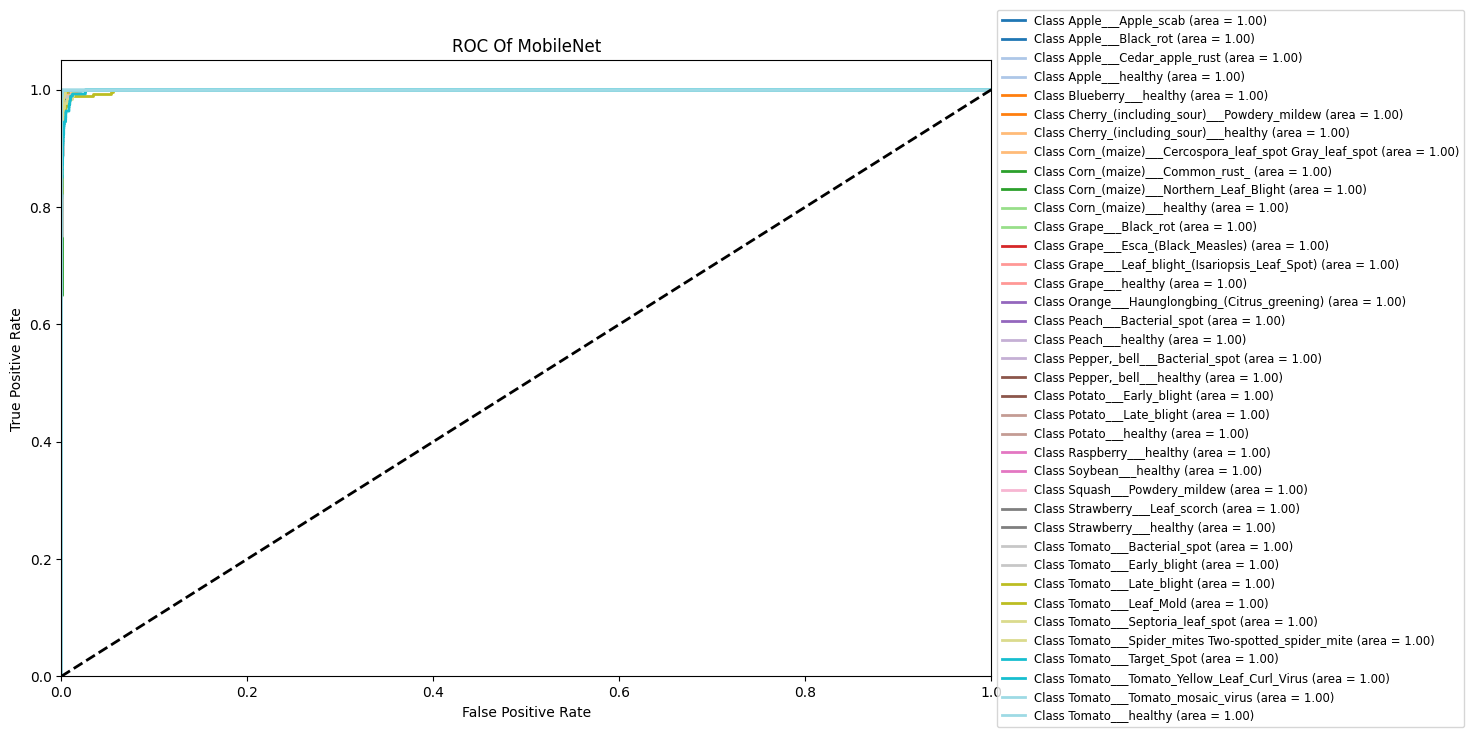

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import matplotlib.cm as cm

# Binarize the output labels for ROC curve calculation
y_true_bin = label_binarize(y_true, classes=list(range(len(class_indices))))
n_classes = y_true_bin.shape[1]

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Generate a colormap with 38 different colors
colors = cm.get_cmap('tab20', n_classes)

# Plotting all ROC curves
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label='Class {0} (area = {1:0.2f})'.format(inverse_class_indices[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Of MobileNet')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize='small')  # Adjusted font size and position
plt.show()